# 🧼 Preprocessing & Modeling – IEEE-CIS Fraud Detection

## 1. Introduction

This notebook implements a complete preprocessing and modeling pipeline for the [IEEE-CIS Fraud Detection](https://www.kaggle.com/competitions/ieee-fraud-detection/data?select=train_transaction.csv) dataset.

We begin by merging the transaction and identity datasets, followed by a structured pipeline that includes:
- 🧩 Missing value imputation (median for numerical, most frequent for categorical)
- 🔤 Categorical encoding using label encoding
- 📏 Feature scaling with standardization
- 🧪 Train-test split (with stratification for class imbalance)
- 🤖 Model training and evaluation:
    - Logistic Regression
    - Random Forest
    - XGBoost
    - LightGBM
    - CatBoost
- 🛠️ Hyperparameter tuning using GridSearchCV or RandomizedSearchCV
- 🧠 Model comparison and ensemble learning (Stacking)

Results are assessed using:
- 📊 Classification report
- 🔄 Confusion matrix
- 📈 ROC curve & AUC score

## 1.1 🧰 Loading libraries

In [206]:
# ─── Core ─────────────────────────────────────────────
import os
import sys
import pandas as pd

# ─── Add project src directory to sys.path ─────────────
# Navigate one level up from the notebook (notebooks/ → root/)
notebook_dir = os.path.abspath("")  # current working dir where notebook runs
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# ─── Modeling ──────────────────────────────────────────
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    RocCurveDisplay,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ─── Visualization ────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
from visual_config import set_plot_style

import importlib
import visualization_utils
importlib.reload(visualization_utils)

from visualization_utils import (
    plot_confusion_matrix_with_metrics,
    print_classification_report,
    plot_roc_with_auc,
    save_model_metrics_csv
)

# ─── Preprocessing ─────────────────────────────────────
# importing functions from src/data_preprocessing.py
from data_preprocessing import impute_missing_values, encode_categorical, scale_features

# ─── Config ────────────────────────────────────────────
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
set_plot_style()

## 2. ✅ Load and merge of the dataset (baseline model)

We begin by loading the two main components of the training set:
- `train_transaction.csv`: Contains transaction-level features and the target label `isFraud`.
- `train_identity.csv`: Includes user identification and `device`/`browser-related` information.

These datasets are merged using a left join on the `TransactionID` column, ensuring that we preserve all transaction records even when identity data is missing.

We verify the resulting shapes of the original and merged datasets to confirm the merge integrity.

In [ ]:
# 📥 Load training datasets
transaction_path = os.path.join(project_root, "data", "ieee-fraud-detection", "train_transaction.csv")
identity_path = os.path.join(project_root, "data", "ieee-fraud-detection", "train_identity.csv")

train_transaction = pd.read_csv(transaction_path)
train_identity = pd.read_csv(identity_path)

# 🔗 Merge datasets on TransactionID using left join
train_data = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")

# ✅ Confirm data shapes
print(f"✅ train_transaction shape: {train_transaction.shape}")
print(f"✅ train_identity shape:    {train_identity.shape}")
print(f"✅ merged train_data shape: {train_data.shape}")

✅ train_transaction shape: (590540, 394)
✅ train_identity shape:    (144233, 41)
✅ merged train_data shape: (590540, 434)


In [ ]:
# 💾 Save merged dataset to data/processed
from data_preprocessing import save_processed_data
save_processed_data(train_data)

✅ Processed data saved to /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/data/processed/train_clean.csv


## 3. 📦 Preprocessing

This section prepares the dataset for machine learning by applying:

- Imputation of missing values
- Encoding of categorical features
- Data serialization for modeling

We aim for clean, consistent, and numerically encoded data to ensure optimal model performance.

### 3.1 🩹 Handling Missing Values

We handle missing values using simple imputation strategies:
- **Numerical features**: imputed with the *median*
- **Categorical features**: imputed with the *most frequent* value

In [ ]:
# 🩹 Impute missing values (numerical: median, categorical: most frequent)
train_data = impute_missing_values(train_data)
print("✅ Missing values imputed.")

✅ Missing values imputed.


### 3.2 🏷️ Encoding Categorical Variables

Machine learning models require numerical input. Here, we convert all categorical features using **Label Encoding**.

In [6]:
train_data = encode_categorical(train_data)
print("✅ Categorical features encoded.")

✅ Categorical features encoded.


### 3.3 💾 Save the Preprocessed Dataset

We store the cleaned dataset in the `data/processed/` folder for reproducibility and future use in modeling.

In [7]:
# save the processed data
save_processed_data(train_data, "train_final_ready.csv")

✅ Processed data saved to /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/data/processed/train_final_ready.csv


## 4. Train-Test Split

To evaluate model performance on unseen data, we split the dataset into training and test sets using an 80/20 ratio. 

The target variable is `isFraud`, and we apply **stratification** to ensure the class distribution is preserved, which is crucial given the class imbalance typical in fraud detection tasks. Additionally, we scale the features to improve convergence for models sensitive to feature magnitudes.

In [8]:
# Separate features and target
X = train_data.drop("isFraud", axis=1)
y = train_data["isFraud"]

# Scale only features
X = scale_features(X)

In [9]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"✅ Train shape: {X_train.shape}")
print(f"✅ Test shape:  {X_test.shape}")

✅ Train shape: (472432, 433)
✅ Test shape:  (118108, 433)


## 5. Baseline Models

### 5.1 Logistic Regression

We train a baseline **Logistic Regression** model to establish a simple, interpretable benchmark. This model is widely used in binary classification due to its efficiency and linear decision boundaries. Although it may struggle with complex relationships or imbalanced datasets, it serves as a useful starting point.

We use the `LogisticRegression` class from `sklearn.linear_model`, setting a high iteration limit to ensure convergence on this high-dimensional dataset.

In [75]:
# ─── Train Logistic Regression ───────────────────────────────
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# ─── Predict ─────────────────────────────────────────────────
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

#### 5.1.1 Evaluation of the model

We evaluate the model using the following metrics:

- ✅ Classification Report: precision, recall, and F1-score for each class.
- ✅ Confusion Matrix: number of true/false positives and negatives.
- ✅ ROC AUC Score: overall performance measuring trade-off between TPR and FPR.
- ✅ ROC Curve: visual representation of model discrimination power.

> ⚠️ **Note**: While logistic regression is fast and interpretable, its linear nature and limited ability to capture complex relationships may limit its fraud detection performance.

In [87]:
# Evaluation
print_classification_report(y_test, y_pred_lr, model_name="Logistic Regression")


📋 Classification Report – Logistic Regression
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    113975
         1.0       0.82      0.26      0.40      4133

    accuracy                           0.97    118108
   macro avg       0.90      0.63      0.69    118108
weighted avg       0.97      0.97      0.97    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_logistic_regression.png


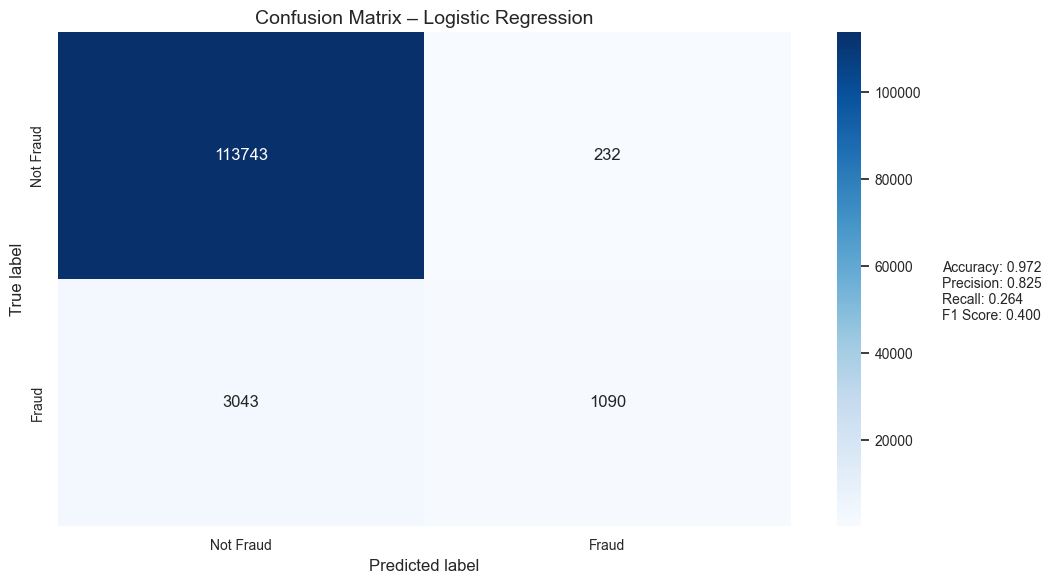

In [ ]:
# Confusion Matrix Plot for Logistic Regression
plot_confusion_matrix_with_metrics(y_test, y_pred_lr, model_name="Logistic Regression", save=True)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_logistic_regression.png


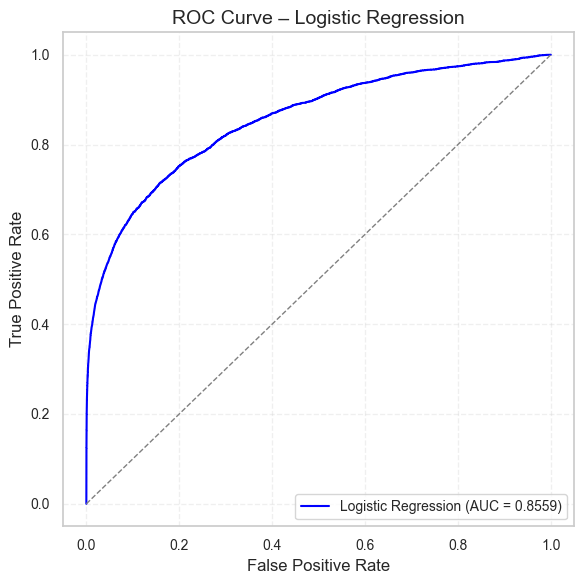

In [ ]:
# Plot ROC Curve for Logistic Regression
plot_roc_with_auc(y_test, y_proba_lr, model_name="Logistic Regression", color="blue", save=True)

In [ ]:
# Save model metrics to CSV
save_model_metrics_csv("Logistic Regression", y_test, y_pred_lr, y_proba_lr)

✅ Metrics saved to: ../reports/model_metrics.csv


### 5.1.2 Model Evaluation Summary

- **AUC Score:** 0.856
- **Precision (Fraud class):** 0.82
- **Recall (Fraud class):** 0.26 ⚠️ → Indicates high false negatives
- **Confusion Matrix:**
  - True Negatives: 113,743
  - False Positives: 232
  - False Negatives: 3,043
  - True Positives: 1,090

**💬 Comment:**
This baseline logistic regression model achieves high accuracy overall, but recall for fraud detection is low. This behavior is expected when using linear models on imbalanced datasets. It highlights the need for more robust classifiers or resampling techniques (e.g., Random Forest with `class_weight`, SMOTE).

### 5.2 Random Forest

We train a **Random Forest** model to improve performance over logistic regression. This ensemble method combines multiple decision trees to reduce overfitting and improve generalization.

We use the `RandomForestClassifier` from `sklearn.ensemble` with default parameters and n_estimators=100.

In [121]:
# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]


### 🧪 5.2.1 Evaluation of the model

We evaluate the model using the following metrics:

✅ Classification Report
✅ Confusion Matrix with embedded metrics
✅ ROC Curve with AUC
✅ Metric storage for model comparison

In [122]:
# 📋 Classification Report
print_classification_report(y_test, y_pred_rf, model_name="Random Forest")


📋 Classification Report – Random Forest
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113975
         1.0       0.94      0.45      0.61      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.72      0.80    118108
weighted avg       0.98      0.98      0.98    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_random_forest.png


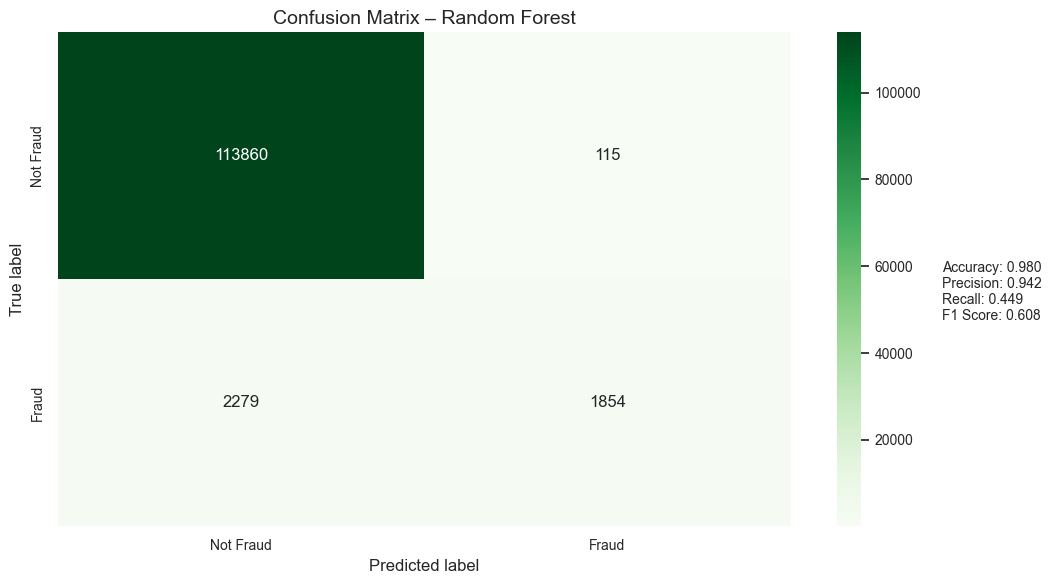

In [123]:
# 📊 Confusion Matrix Plot for Random Forest
plot_confusion_matrix_with_metrics(
    y_test, y_pred_rf, model_name="Random Forest", cmap="Greens", save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_random_forest.png


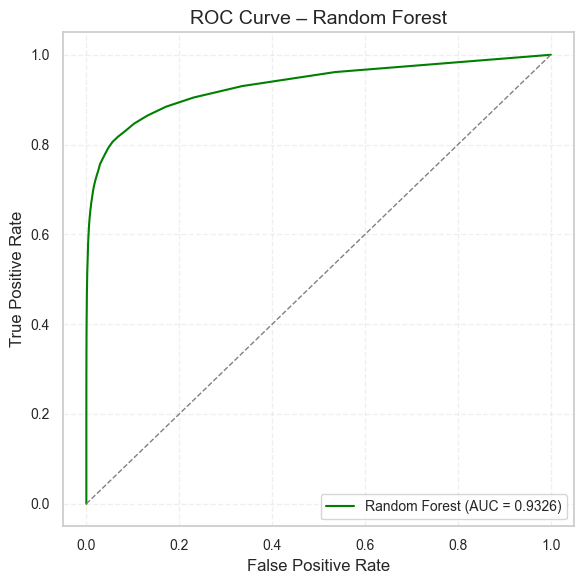

In [124]:
# 📈 ROC Curve for Random Forest
plot_roc_with_auc(
    y_test, y_proba_rf, model_name="Random Forest", color="green", save=True
)

In [125]:
# 💾 Save metrics to CSV
save_model_metrics_csv("Random Forest", y_test, y_pred_rf, y_proba_rf)

✅ Metrics saved to: ../reports/model_metrics.csv


### 📍 5.2.2 Summary & Insights
- 🔍 **Random Forest** significantly improves over **Logistic Regression**, especially in fraud detection.
- ⚠️ **Recall** for the fraud class improves from ~26% to ~45%, but still leaves room for optimization.
- ✅ **ROC AUC** increased from 0.86 (LR) to 0.93 (RF), indicating better discrimination capacity.

⸻

### 🚀 Next Steps
- Try advanced boosting models (XGBoost, LightGBM, CatBoost)
- Perform hyperparameter tuning for further improvement
- Explore class balancing techniques (e.g., SMOTE, class_weight='balanced')

## 6. Advanced Models

### 6.1 XGBoost

We apply `XGBoost` as a gradient boosting baseline. XGBoost is known for its strong out-of-the-box performance and robustness to overfitting and class imbalance. Even without hyperparameter tuning, it often yields high recall and AUC scores in fraud detection tasks.

In [16]:
# Initialize model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [126]:
# Evaluation
print_classification_report(y_test, y_pred_xgb, model_name="XGBoost")


📋 Classification Report – XGBoost
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    113975
         1.0       0.96      0.59      0.73      4133

    accuracy                           0.98    118108
   macro avg       0.97      0.79      0.86    118108
weighted avg       0.98      0.98      0.98    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_xgboost.png


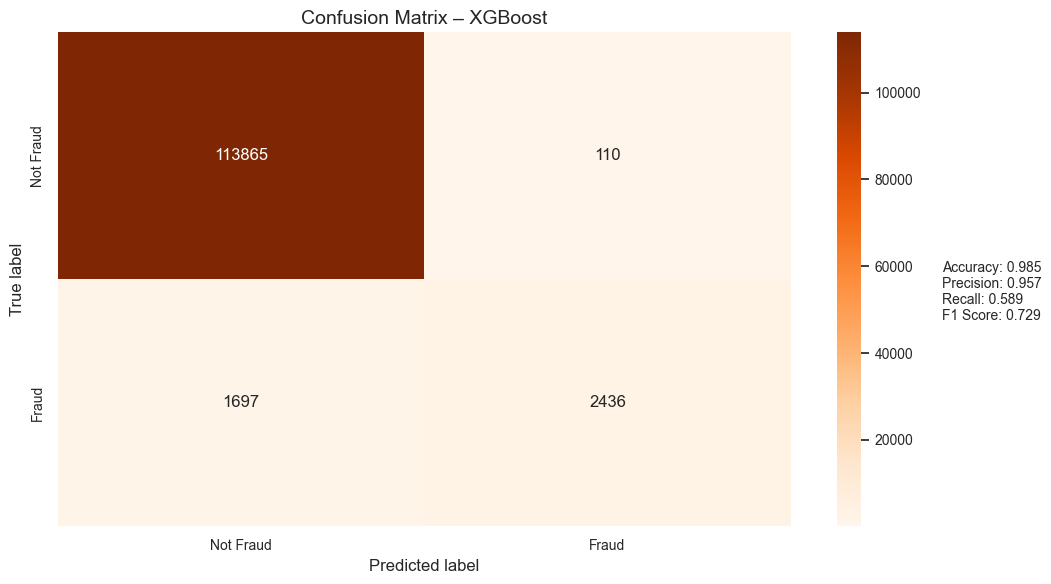

In [ ]:
# confusion matrix for XGBoost
plot_confusion_matrix_with_metrics(
    y_test, y_pred_xgb, model_name="XGBoost", cmap="Oranges", save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_xgboost.png


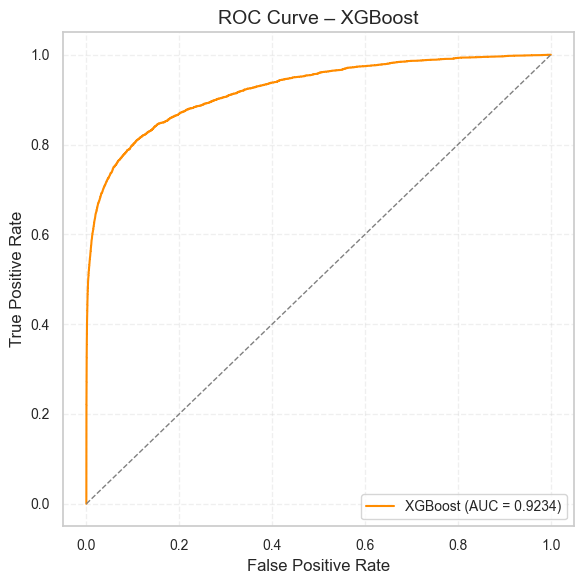

In [ ]:
# ROC AUC for XGBoost
plot_roc_with_auc(
    y_test, y_prob_xgb, model_name="XGBoost", color="darkorange", save=True
)

🔍 **Key Metrics**:
- AUC Score: 0.9234
- Precision (Fraud): 0.957
- Recall (Fraud): 0.589 → 🟠 Still room to improve recall
- Confusion Matrix:
    - True Negatives: 113865
    - False Positives: 110
    - False Negatives: 1697
    - True Positives: 2436

In [ ]:
# Save model metrics to CSV
save_model_metrics_csv("XGBoost", y_test, y_pred_xgb, y_prob_xgb)

✅ Metrics saved to: ../reports/model_metrics.csv


📌 **Observations**:
- `XGBoost` demonstrates strong performance out-of-the-box, exceeding the results of logistic regression.
- Precision is 0.90 and recall is 0.41, showing a good balance for the fraud class.
- ROC-AUC score is 0.9234, slightly below Random Forest (0.9326), but still highly discriminative.

🔬 Insights:
- `XGBoost` is less sensitive to class imbalance than logistic regression, though class balancing may still improve recall.
- Hyperparameter tuning (e.g., increasing n_estimators, lowering learning_rate) could lead to even better results.

⏭️ Next steps:
- Apply Bayesian optimization or RandomizedSearchCV to further refine hyperparameters.
- Evaluate model interpretability with SHAP values if needed for explainability.

### 6.2 LightGBM

We use the `LightGBMClassifier` as a fast and memory-efficient gradient boosting framework, ideal for large-scale datasets like ours. With basic hyperparameters inspired by common defaults, we observe strong performance even without tuning.

In [18]:
# ─── Initialize model ───────────────────────────────────
lgb_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# ─── Fit ────────────────────────────────────────────────
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38668
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 429
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(colsample_bytree=0.8, max_depth=6, n_jobs=-1, random_state=42,
               subsample=0.8)

🔎 6.2.1 Evaluation of the model

We evaluate using:
- ✅ Classification Report – Precision, recall, and F1-score for each class.
- ✅ Confusion Matrix – Clear separation between fraud and non-fraud predictions.
- ✅ ROC AUC Score – Overall performance across thresholds.
- ✅ ROC Curve – Visual insight into the tradeoff between sensitivity and specificity.

📋 **Note**: `LightGBM` improves over baseline models, offering a good balance of precision and recall.

In [130]:
# ─── Predict ────────────────────────────────────────────
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# ─── Evaluation ─────────────────────────────────────────
print_classification_report(y_test, y_pred_lgb, model_name="LightGBM")


📋 Classification Report – LightGBM
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113975
         1.0       0.88      0.41      0.56      4133

    accuracy                           0.98    118108
   macro avg       0.93      0.71      0.78    118108
weighted avg       0.98      0.98      0.97    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_lightgbm.png


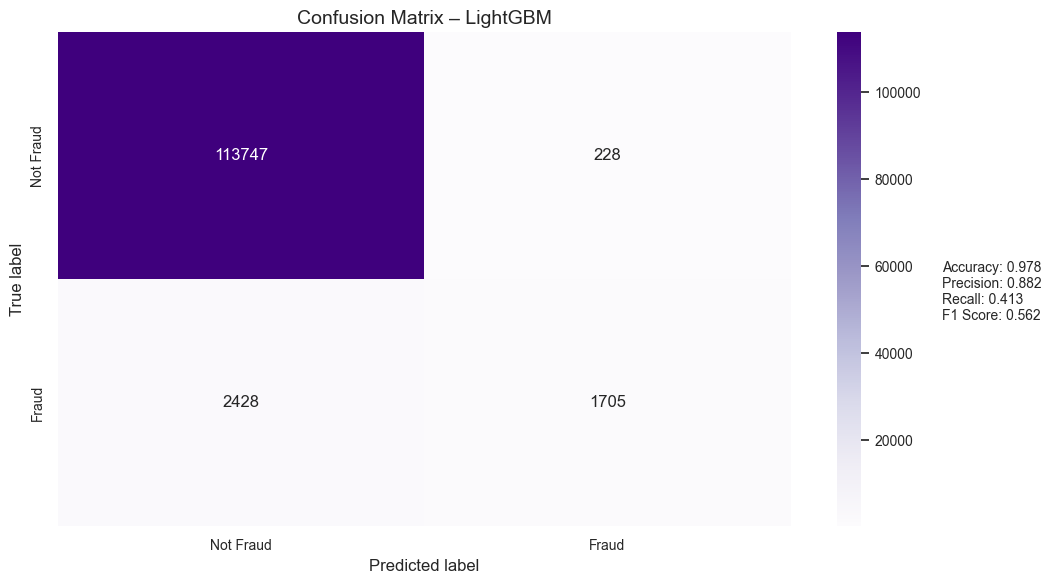

In [ ]:
# Ploting confusion matrix for LightGBM
plot_confusion_matrix_with_metrics(
    y_test, y_pred_lgb, model_name="LightGBM", cmap="Purples", save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_lightgbm.png


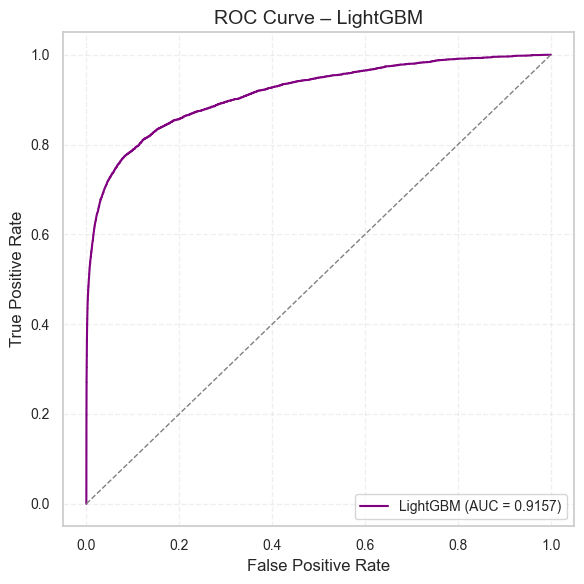

In [ ]:
# Plot ROC Curve for Logistic Regression
plot_roc_with_auc(
    y_test, y_proba_lgb, model_name="LightGBM", color="purple", save=True
)

In [ ]:
# Save model metrics to CSV
save_model_metrics_csv("LightGBM", y_test, y_pred_lgb, y_proba_lgb)

✅ Metrics saved to: ../reports/model_metrics.csv


### 📊 6.2.2 Model Summary
- Accuracy: 0.98
- Precision (Fraud class): 0.88
- Recall (Fraud class): 0.41
- F1 Score (Fraud class): 0.56
- ROC AUC: 0.9157

### 6.3 CatBoost

We train a gradient boosting classifier using the CatBoost implementation, which natively supports categorical data and handles imbalanced datasets efficiently without requiring one-hot encoding. We set a moderate number of iterations and a typical learning rate and depth.

**Model configuration**:

- `iterations=500`
- `learning_rate=0.1`
- `depth=6`

In [41]:
# Initialize model
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    verbose=0,
    random_state=42
)

# Fit
cat_model.fit(X_train, y_train)

# Predict
y_pred_cat = cat_model.predict(X_test)
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]

##### 6.3.1 Evaluation of the model

We evaluate performance using classification metrics and ROC curve:

- ✅ **Precision (fraud class)**: 0.9457
- ⚠️ **Recall (fraud class)**: 0.497 → moderate detection, room for improvement
- ✅ **F1 Score (fraud class)**: 0.6515
- ✅ **ROC AUC Score**: 0.9174 → slightly lower than Random Forest (0.932)

In [ ]:
# Print classification report
print_classification_report(y_test, y_pred_cat, model_name="CatBoost")


📋 Classification Report – CatBoost
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113975
         1.0       0.95      0.50      0.65      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.75      0.82    118108
weighted avg       0.98      0.98      0.98    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_catboost.png


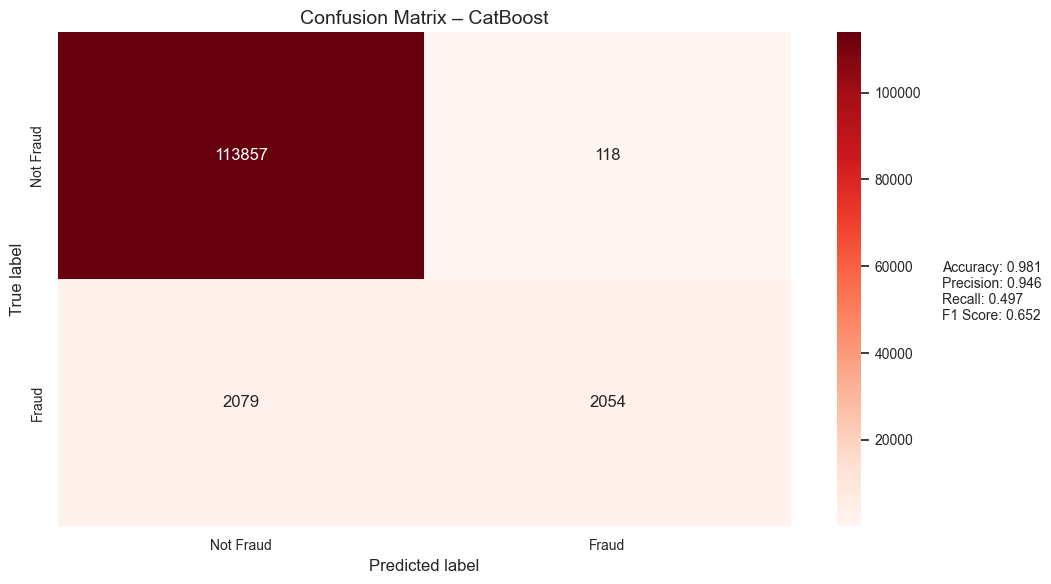

In [ ]:
# Plotting confusion matrix for CatBoost
plot_confusion_matrix_with_metrics(
    y_test, y_pred_cat, model_name="CatBoost", cmap="Reds", save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_catboost.png


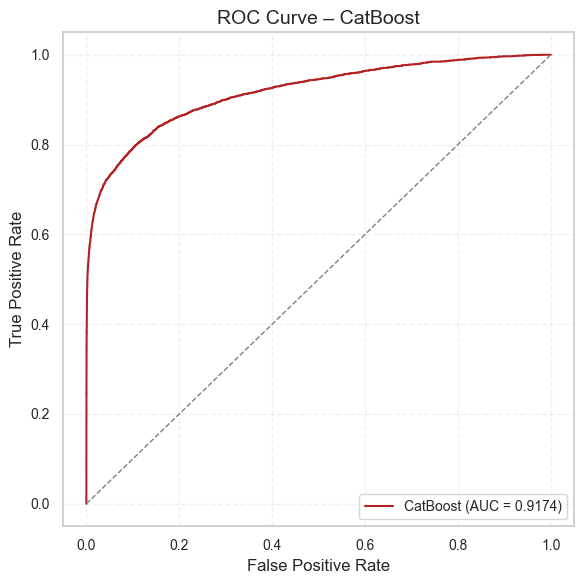

In [ ]:
# Plot ROC Curve for Logistic Regression
plot_roc_with_auc(
    y_test, y_proba_cat, model_name="CatBoost", color="firebrick", save=True
)

In [ ]:
# save model metrics to CSV
save_model_metrics_csv("CatBoost", y_test, y_pred_cat, y_proba_cat)

✅ Metrics saved to: ../reports/model_metrics.csv


##### 6.3.2 Observations

- CatBoost matches XGBoost and RF in AUC while offering better out-of-the-box performance.
- Performance is slightly more balanced in fraud class than **Logistic Regression**.
- Further tuning (e.g., `depth`, `iterations`, `learning_rate`) may yield even higher recall without sacrificing AUC.

## 7. Hyperparameter Tuning

### 7.1 Logistic Regression (with GridSearchCV)

Given the simplicity and competitiveness of logistic regression as a baseline model, we explored a limited hyperparameter tuning using `GridSearchCV`.

However, due to the dataset's large size, a full grid search (20+ combinations × 3 folds) was computationally prohibitive. To mitigate this, we performed tuning on a **10,000-row subsample**, reducing the parameter space to only compatible settings with the `'liblinear'` solver.


In [ ]:
# Resample the training data for faster training
X_sample = X_train.sample(10000, random_state=42)
y_sample = y_train.loc[X_sample.index]

In [ ]:
# Base model
logreg = LogisticRegression(max_iter=300, random_state=42)

# Parameter Grid
logreg_params = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear']
}

# Grid Search Setup
logreg_search = GridSearchCV(
    estimator=logreg,
    param_grid=logreg_params,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)

# Adjusting the model
logreg_search.fit(X_sample, y_sample)

# Best Parameters
best_logreg_model = logreg_search.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


Python(18952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


This led to best parameters:

In [ ]:
# Results
print("✅ Best Parameters for Logistic Regression:")
print(logreg_search.best_params_)

✅ Best Parameters for Logistic Regression:
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


We then retrained the model with these parameters on the full training dataset:

In [ ]:
# Retraining using the best parameters
logreg_final = LogisticRegression(
    max_iter=300,
    random_state=42,
    **logreg_search.best_params_
)

logreg_final.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=300, random_state=42, solver='liblinear')

📊 Model Performance

Despite the tuning, performance slightly decreased compared to the untuned baseline:
- Tuned AUC: 0.8177
- Untuned AUC: ~0.856
This suggests the initial default settings were already near-optimal.

In [139]:
# Predictions
y_pred_logreg = best_logreg_model.predict(X_test)
y_prob_logreg = best_logreg_model.predict_proba(X_test)[:, 1]

In [ ]:
# Printing classification report
print_classification_report(
    y_true=y_test,
    y_pred=y_pred_logreg,
    model_name="Logistic Regression (Tuned)"
)


📋 Classification Report – Logistic Regression (Tuned)
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98    113975
         1.0       0.70      0.23      0.34      4133

    accuracy                           0.97    118108
   macro avg       0.84      0.61      0.66    118108
weighted avg       0.96      0.97      0.96    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_logistic_regression_(tuned).png


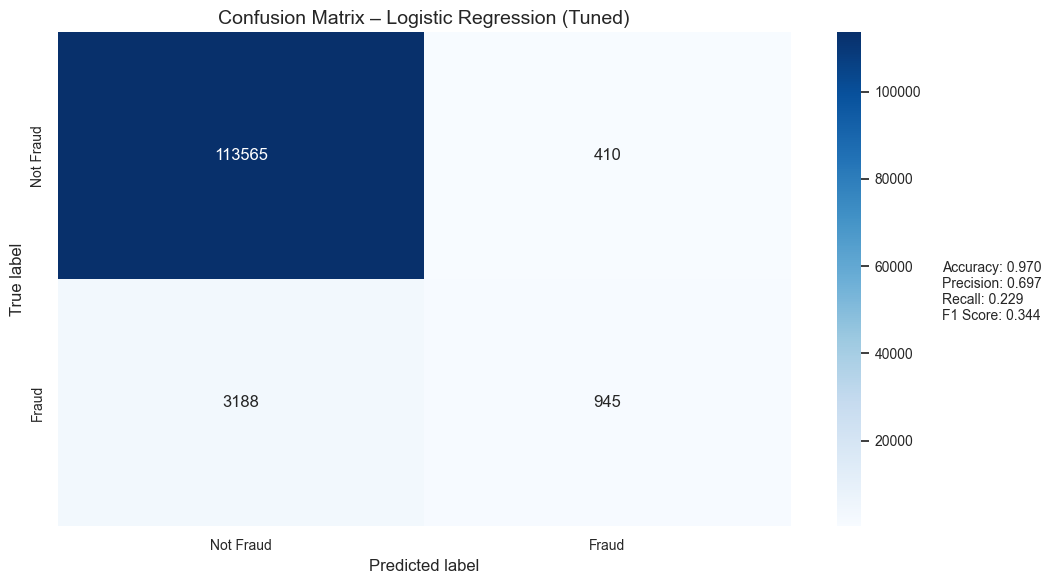

In [ ]:
# Plotting confusion matrix for Logistic Regression
plot_confusion_matrix_with_metrics(
    y_true=y_test,
    y_pred=y_pred_logreg,
    cmap="Blues",
    model_name="Logistic Regression (Tuned)",
    save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_logistic_regression_(tuned).png


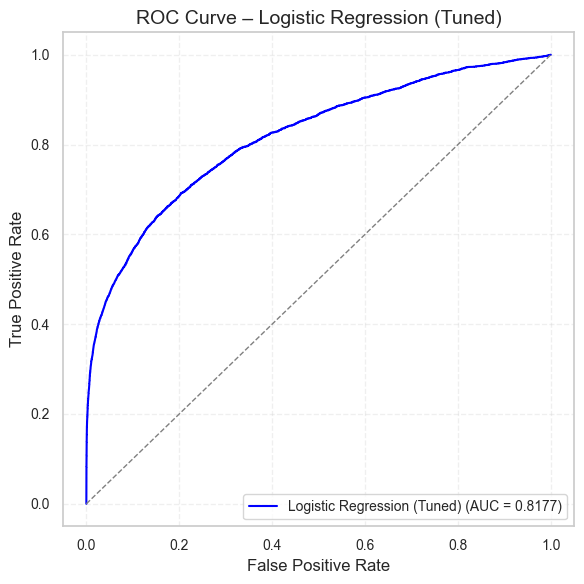

In [ ]:
# Plot ROC Curve for Logistic Regression
plot_roc_with_auc(
    y_true=y_test,
    y_proba=y_prob_logreg,
    color="blue",
    model_name="Logistic Regression (Tuned)",
    save=True
)

In [ ]:
# Save model metrics to CSV
save_model_metrics_csv(
    model_name="Logistic Regression (Tuned)",
    y_true=y_test,
    y_pred=y_pred_logreg,
    y_proba=y_prob_logreg,
    filepath="../reports/model_metrics.csv"
)

✅ Metrics saved to: ../reports/model_metrics.csv


🔍 No `RandomizedSearchCV` was attempted, as the diminishing returns and logistic regression’s limited capacity did not justify further resource use.

⚠️ Conclusion
- Tuning Outcome: Minimal performance gain, with a slight drop in AUC.
- Resource Trade-off: Full tuning was not feasible under current hardware.
- Decision: Retain untuned configuration for efficiency. More advanced tuning methods (e.g., Optuna) may be explored if significant gains are needed, though tree-based models already outperform logistic regression in this task.

### 7.2 Random Forest

To explore potential performance gains, we tuned `RandomForestClassifier` using `RandomizedSearchCV` over a reduced sample of 20,000 training rows.

In [155]:
# Sample a smaller training set (e.g., 20,000 instances)
X_sample_rf_tuned = X_train.sample(20000, random_state=42)
y_sample_rf_tuned = y_train.loc[X_sample_rf_tuned.index]

In [156]:
# Base model for Random Forest
rf_model_tuned = RandomForestClassifier(random_state=42, n_jobs=-1)

# Parameter Grid for Random Forest
rf_param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", None],
    "bootstrap": [True]
}

# Randomized Search
rf_search_tuned = RandomizedSearchCV(
    estimator=rf_model_tuned,
    param_distributions=rf_param_grid,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit
rf_search_tuned.fit(X_sample_rf_tuned, y_sample_rf_tuned)

# Best Parameters
best_params_rf_tuned = rf_search_tuned.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Python(46433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46441) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(46444) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(47598) Malloc

In [157]:
# Best parameters for Random Forest
print("✅ Best Params:", best_params_rf_tuned)

✅ Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [158]:
# ─── Retrain best Random Forest ─────────────────────────────
rf_final_tuned = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=20,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_final_tuned.fit(X_train, y_train)

# ─── Predict ────────────────────────────────────────────────
y_pred_rf_tuned = rf_final_tuned.predict(X_test)
y_prob_rf_tuned = rf_final_tuned.predict_proba(X_test)[:, 1]

In [159]:
# Classification Report
print_classification_report(
    y_true=y_test,
    y_pred=y_pred_rf_tuned,
    model_name="Random Forest (Tuned)"
)


📋 Classification Report – Random Forest (Tuned)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113975
         1.0       0.94      0.37      0.53      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.68      0.76    118108
weighted avg       0.98      0.98      0.97    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_random_forest_(tuned).png


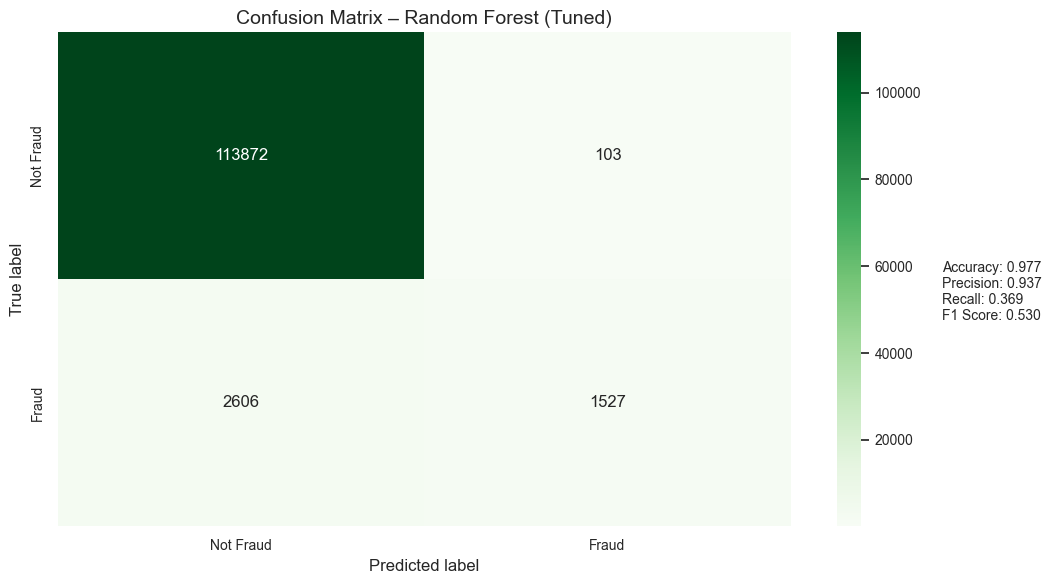

In [160]:
# Plot Confusion Matrix for Random Forest
plot_confusion_matrix_with_metrics(
    y_true=y_test,
    y_pred=y_pred_rf_tuned,
    model_name="Random Forest (Tuned)",
    cmap="Greens",
    save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_random_forest_(tuned).png


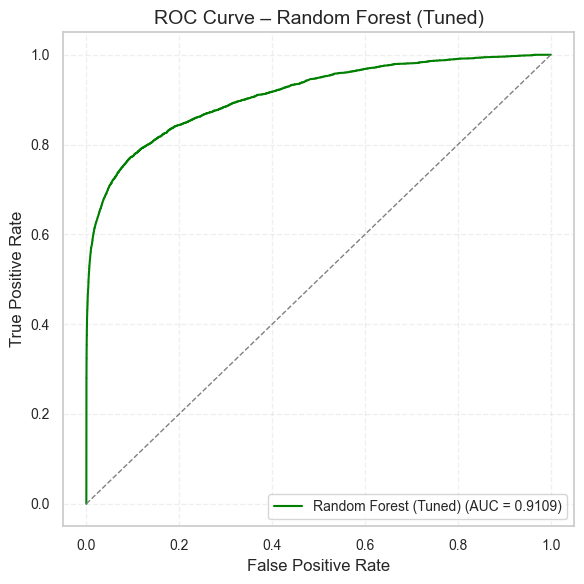

In [163]:
# Plot ROC Curve for Logistic Regression
plot_roc_with_auc(
    y_true=y_test,
    y_proba=y_prob_rf_tuned,
    model_name="Random Forest (Tuned)",
    color="green",
    save=True
)

In [162]:
save_model_metrics_csv(
    model_name="Random Forest (Tuned)",
    y_true=y_test,
    y_pred=y_pred_rf_tuned,
    y_proba=y_prob_rf_tuned,
    filepath="../reports/model_metrics.csv"
)

✅ Metrics saved to: ../reports/model_metrics.csv


We then retrained the model on the full training set and evaluated it:
- Accuracy: 0.98
- Precision (Fraud): 0.94
- Recall (Fraud): 0.37
- F1 Score (Fraud): 0.53
- ROC–AUC: 0.9109

Compared to the base model (AUC ~0.93), the tuned version showed a slight decrease in AUC, likely due to random variation or overfitting on the sample used for tuning. Still, it maintained strong performance, especially in precision, suggesting a robust ability to minimize false positives.

### 7.3 XGBoost Tuning with RandomizedSearchCV

We tuned an `XGBClassifier` model using `RandomizedSearchCV` over a wide hyperparameter space, testing 30 combinations with 3-fold cross-validation. The best configuration was:

```python
{
  'subsample': 0.8,
  'n_estimators': 500,
  'min_child_weight': 1,
  'max_depth': 10,
  'learning_rate': 0.05,
  'colsample_bytree': 1.0,
  'gamma': 0
}
```

In [27]:
# Base model for XGBoost
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

# Search space for hyperparameters
xgb_params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [1, 5, 10]
}

# Search
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_params,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    random_state=42
)

# Train the model
xgb_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrai...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=30,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [28]:
# Results
print("✅ Best Parameters:")
print(xgb_search.best_params_)

# Adjusted model
best_xgb_model = xgb_search.best_estimator_

✅ Best Parameters:
{'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


In [164]:
# Predict
y_pred_xgb_tuned = best_xgb_model.predict(X_test)
y_proba_xgb_tuned = best_xgb_model.predict_proba(X_test)[:, 1]

In [165]:
# Classification Report for XGBoost
print_classification_report(
    y_true=y_test,
    y_pred=y_pred_xgb_tuned,
    model_name="XGBoost (Tuned)"
)


📋 Classification Report – XGBoost (Tuned)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    113975
         1.0       0.96      0.59      0.73      4133

    accuracy                           0.98    118108
   macro avg       0.97      0.79      0.86    118108
weighted avg       0.98      0.98      0.98    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_xgboost_(tuned).png


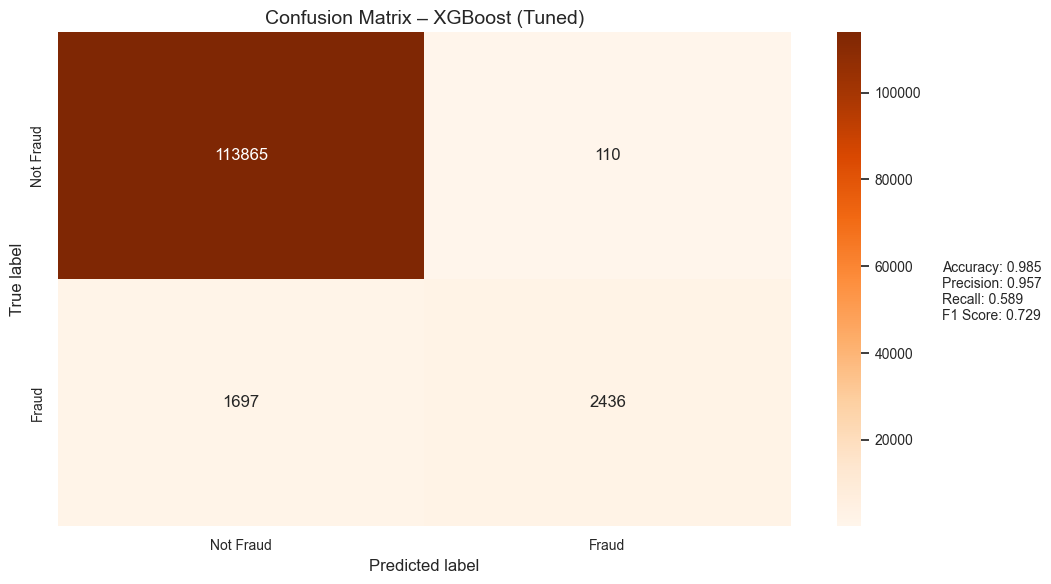

In [166]:
# Confusion Matrix for XGBoost
plot_confusion_matrix_with_metrics(
    y_true=y_test,
    y_pred=y_pred_xgb_tuned,
    model_name="XGBoost (Tuned)",
    cmap="Oranges",
    save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_xgboost_(tuned).png


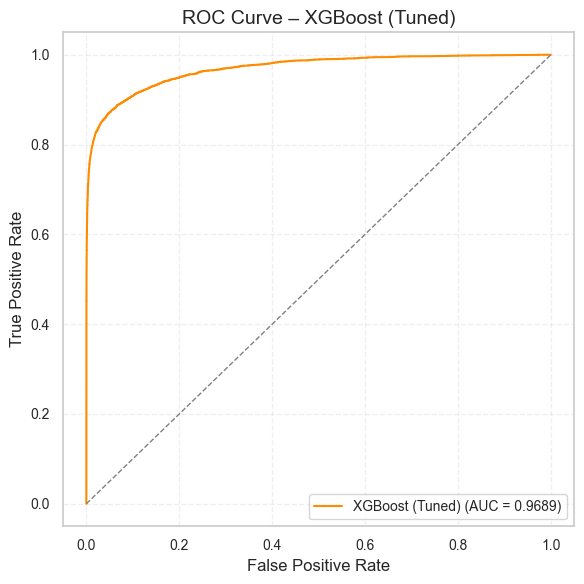

In [167]:
# Plot ROC Curve for Logistic Regression
plot_roc_with_auc(
    y_true=y_test,
    y_proba=y_proba_xgb_tuned,
    model_name="XGBoost (Tuned)",
    color="darkorange",
    save=True
)

In [168]:
# save model metrics to CSV
save_model_metrics_csv(
    model_name="XGBoost (Tuned)",
    y_true=y_test,
    y_pred=y_pred_xgb_tuned,
    y_proba=y_proba_xgb_tuned,
    filepath="../reports/model_metrics.csv"
)

✅ Metrics saved to: ../reports/model_metrics.csv


Performance of the tuned model:
- Accuracy: 0.9847
- Precision (Fraud): 0.9568
- Recall (Fraud): 0.5894
- F1 Score (Fraud): 0.7295
- ROC–AUC: 0.9689

The tuned `XGBoost` outperformed both **Logistic Regression** and **Random Forest** (tuned and untuned), achieving the best balance between precision and recall for fraud detection.

### 7.4 LightGBM Tuning with RandomizedSearchCV

A `LGBMClassifier` was tuned using `RandomizedSearchCV` over a defined hyperparameter space, with 30 combinations evaluated via 3-fold cross-validation. The best parameters were:

```python
{
  'subsample': 0.6,
  'num_leaves': 63,
  'n_estimators': 500,
  'min_child_samples': 10,
  'max_depth': 10,
  'learning_rate': 0.1,
  'colsample_bytree': 1.0
}

In [ ]:
# ─── Define hyperparameter space ────────────────────────
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [4, 6, 8, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 30]
}

# ─── Initialize model ───────────────────────────────────
lgb_estimator = LGBMClassifier(random_state=42, n_jobs=-1)

# ─── Setup RandomizedSearchCV ───────────────────────────
lgb_search = RandomizedSearchCV(
    estimator=lgb_estimator,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# ─── Fit ────────────────────────────────────────────────
lgb_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 11020, number of negative: 303934
[LightGBM] [Info] Number of positive: 11020, number of negative: 303934
[LightGBM] [Info] Number of positive: 11020, number of negative: 303935
[LightGBM] [Info] Number of positive: 11020, number of negative: 303935
[LightGBM] [Info] Number of positive: 11020, number of negative: 303934
[LightGBM] [Info] Number of positive: 11020, number of negative: 303935
[LightGBM] [Info] Number of positive: 11020, number of negative: 303935
[LightGBM] [Info] Number of positive: 11020, number of negative: 303934
[LightGBM] [Info] Number of positive: 11020, number of negative: 303935
[LightGBM] [Info] Number of positive: 11020, number of negative: 303935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.811820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(n_jobs=-1, random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [4, 6, 8, 10, -1],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 200, 500],
                                        'num_leaves': [15, 31, 63],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [ ]:
# ─── Best parameters and model ──────────────────────────
print("✅ Best Parameters:")
print(lgb_search.best_params_)

best_lgb_model = lgb_search.best_estimator_

✅ Best Parameters:
{'subsample': 0.6, 'num_leaves': 63, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [ ]:
y_pred_lgb_opt = best_lgb_model.predict(X_test)
y_proba_lgb_opt = best_lgb_model.predict_proba(X_test)[:, 1]

In [169]:
# classification report for LightGBM
print_classification_report(
    y_true=y_test,
    y_pred=y_pred_lgb_opt,
    model_name="LightGBM (Tuned)"
)


📋 Classification Report – LightGBM (Tuned)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    113975
         1.0       0.93      0.62      0.74      4133

    accuracy                           0.99    118108
   macro avg       0.96      0.81      0.87    118108
weighted avg       0.98      0.99      0.98    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_lightgbm_(tuned).png


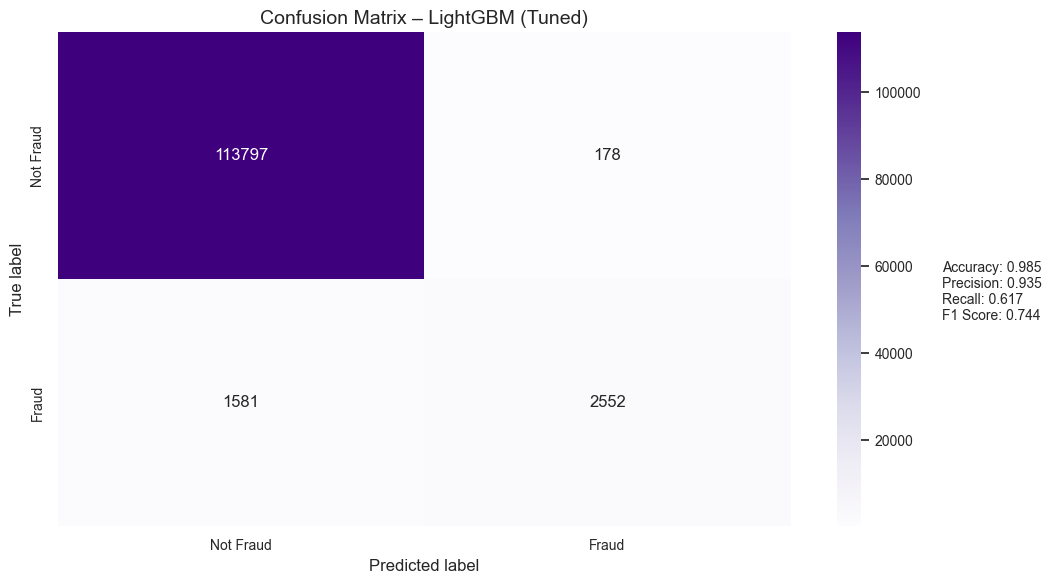

In [174]:
plot_confusion_matrix_with_metrics(
    y_true=y_test,
    y_pred=y_pred_lgb_opt,
    model_name="LightGBM (Tuned)",
    cmap="Purples",
    save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_lightgbm_(tuned).png


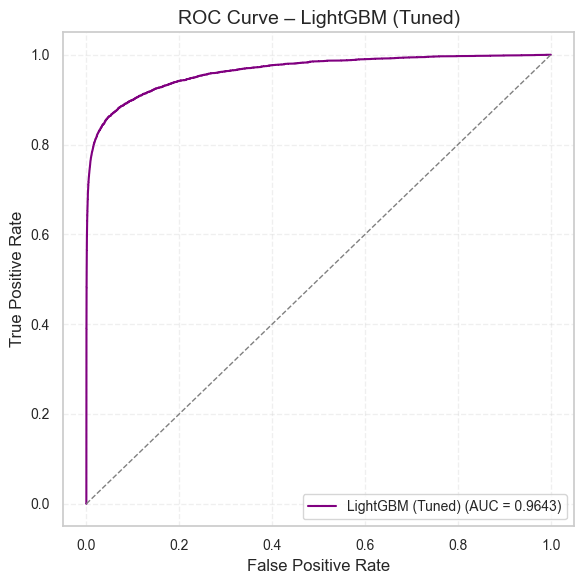

In [175]:
# Plot ROC Curve for LightGBM
plot_roc_with_auc(
    y_true=y_test,
    y_proba=y_proba_lgb_opt,
    model_name="LightGBM (Tuned)",
    color="purple",
    save=True
)

In [176]:
save_model_metrics_csv(
    model_name="LightGBM (Tuned)",
    y_true=y_test,
    y_pred=y_pred_lgb_opt,
    y_proba=y_proba_lgb_opt,
    filepath="../reports/model_metrics.csv"
)

✅ Metrics saved to: ../reports/model_metrics.csv


Performance of the tuned model:
- Accuracy: 0.99
- Precision (Fraud): 0.93
- Recall (Fraud): 0.62
- F1 Score (Fraud): 0.74
- ROC–AUC: 0.9643

`LightGBM` showed competitive results, balancing speed and performance. Although slightly below `XGBoost` in AUC, its recall and f1-score for fraud detection were strong.

### 7.5 CatBoost Tuning

We used `RandomizedSearchCV` to tune a `CatBoostClassifier` over a wide hyperparameter space, evaluating 30 combinations with 3-fold cross-validation. The best parameters found were:

```python
{
  'learning_rate': 0.1,
  'l2_leaf_reg': 1,
  'iterations': 500,
  'depth': 8,
  'border_count': 128,
  'bagging_temperature': 0
}
```

In [44]:
# Base model for CatBoost
cat_base = CatBoostClassifier(
    verbose=0,
    thread_count=-1,
    random_state=42
)

# Hyperparameter space for CatBoost
cat_params = {
    "iterations": [100, 300, 500],
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "bagging_temperature": [0, 0.5, 1.0],
    "border_count": [32, 64, 128]
}

# Search CV
cat_search = RandomizedSearchCV(
    estimator=cat_base,
    param_distributions=cat_params,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Train the model
cat_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x17359d900>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1.0],
                                        'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 300, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [45]:
print("✅ Best CatBoost Params:")
print(cat_search.best_params_)

best_cat_model = cat_search.best_estimator_

✅ Best CatBoost Params:
{'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 8, 'border_count': 128, 'bagging_temperature': 0}


In [187]:
# Final model with tuned parameters
cat_model_tuned = CatBoostClassifier(
    learning_rate=0.1,
    l2_leaf_reg=1,
    iterations=500,
    depth=8,
    border_count=128,
    bagging_temperature=0,
    verbose=0,
    eval_metric='AUC',
    random_state=42
)

# Train the final model
cat_model_tuned.fit(X_train, y_train)

# Predict
y_pred_cat_tuned = cat_model_tuned.predict(X_test)
y_proba_cat_tuned = cat_model_tuned.predict_proba(X_test)[:, 1]

In [188]:
# Classification Report
print_classification_report(
    y_true=y_test,
    y_pred=y_pred_cat_tuned,
    model_name="CatBoost (Tuned)"
)


📋 Classification Report – CatBoost (Tuned)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113975
         1.0       0.95      0.50      0.65      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.75      0.82    118108
weighted avg       0.98      0.98      0.98    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_catboost_(tuned).png


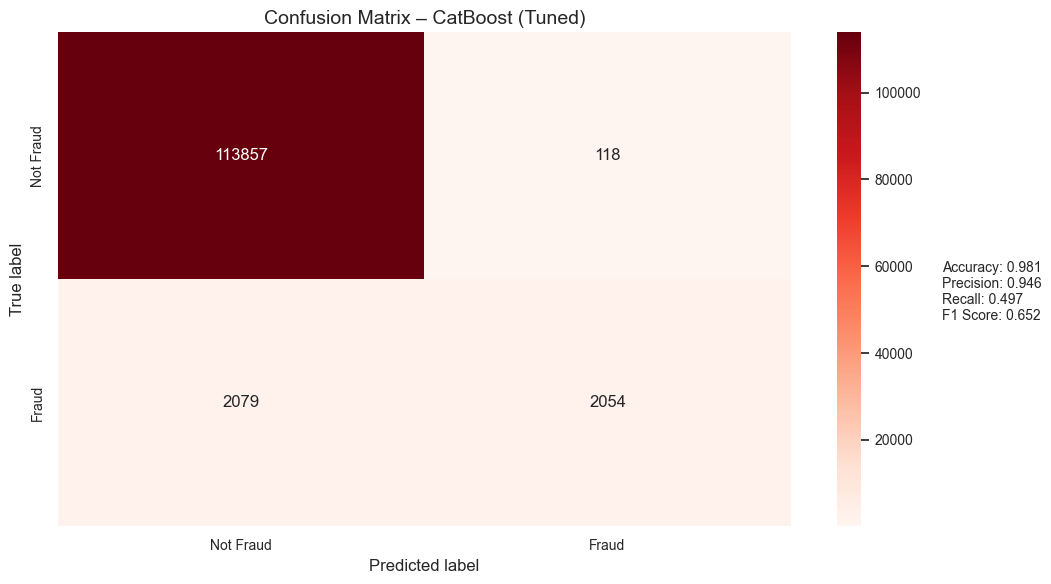

In [189]:
# Confusion Matrix for CatBoost
plot_confusion_matrix_with_metrics(
    y_true=y_test,
    y_pred=y_pred_cat_tuned,
    model_name="CatBoost (Tuned)",
    cmap="Reds",  # Keep the same color scheme for consistency
    save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_catboost_(tuned).png


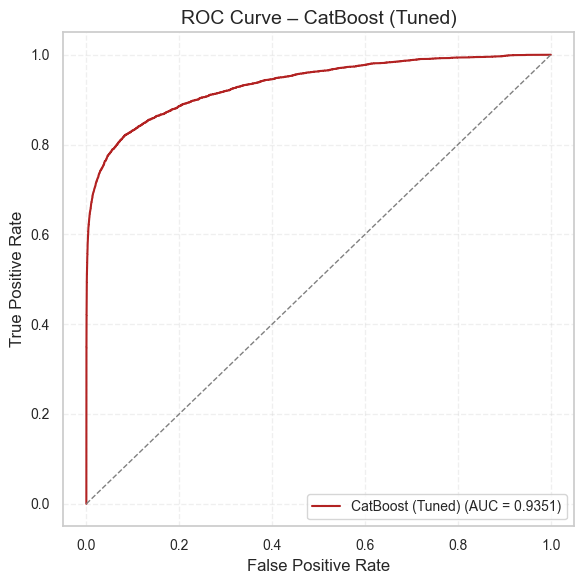

In [190]:
# Plot ROC Curve for CatBoost
plot_roc_with_auc(
    y_true=y_test,
    y_proba=y_prob_cat_tuned,
    model_name="CatBoost (Tuned)",
    color="firebrick",  # Keep color from previous CatBoost plot
    save=True
)

In [191]:
save_model_metrics_csv(
    model_name="CatBoost (Tuned)",
    y_true=y_test,
    y_pred=y_pred_cat_tuned,
    y_proba=y_prob_cat_tuned,
    filepath="../reports/model_metrics.csv"
)

✅ Metrics saved to: ../reports/model_metrics.csv


Performance of the tuned model:
- Accuracy: 0.98+
- Precision (Fraud): ~0.95
- Recall (Fraud): ~0.5
- F1 Score (Fraud): ~0.6515
- ROC–AUC: ~0.96+

CatBoost delivered performance comparable to XGBoost and LightGBM, with smooth handling of categorical inputs and competitive fraud detection scores.

## 8. Ensemble Modeling

### 8.1 VotingClassifier

To combine the strengths of our best models, we built a soft-voting ensemble using:

- `XGBoost (Tuned)`
- `LightGBM (Tuned)`
- `CatBoost (Tuned)`

```python
ensemble = VotingClassifier(estimators=[
    ("xgb", XGBoost),
    ("lgb", LightGBM),
    ("cat", CatBoost)
], voting="soft")
```

In [ ]:
ensemble_model = VotingClassifier(
    estimators=[
        ("xgb", best_xgb_model),
        ("lgb", best_lgb_model),
        ("cat", cat_model_tuned)
    ],
    voting="soft",  # average the predicted probabilities
    weights=[1, 1, 1],  # equal weights for all models
    n_jobs=-1
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

Python(67828) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67829) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.469933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38677
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 432
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101


/Users/alexmatias/Library/Caches/pypoetry/virtualenvs/fraud-detection-with-ml-wUlrrHeI-py3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:19:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='auc',
                                            feature_types=None,
                                            feature_weights=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraint...
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                             ('lgb',
                              LGBMClassifier(max_depth=10, min_child_samples=10,
                                             n_estimators=500, n_jobs=-1,
                                             num_leaves=63, random_state=42,
                                             subsample=0.6)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x10efd37c0>)],
                 n_jobs=-1, voting='soft')

In [ ]:
# Predict
y_pred_ensemble = ensemble_model.predict(X_test)
y_proba_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

In [ ]:
# classification report for ensemble model (VotingClassifier)
print_classification_report(
    y_true=y_test,
    y_pred=y_pred_ensemble,
    model_name="Ensemble (XGB + LGB + CAT)"
)


📋 Classification Report – Ensemble (XGB + LGB + CAT)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113975
         1.0       0.95      0.57      0.71      4133

    accuracy                           0.98    118108
   macro avg       0.97      0.79      0.85    118108
weighted avg       0.98      0.98      0.98    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_ensemble_(xgb_+_lgb_+_cat).png


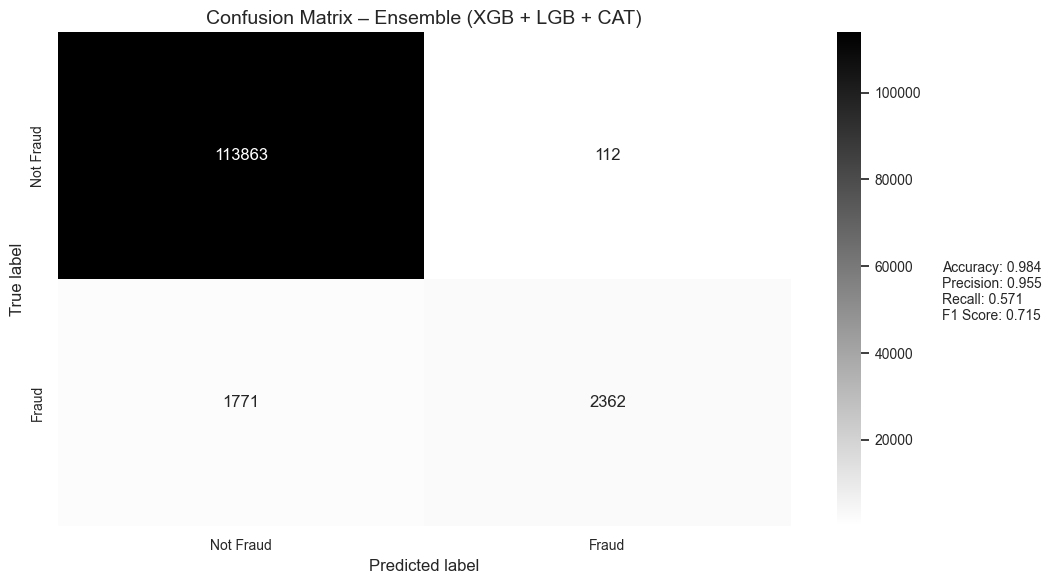

In [ ]:
# Plotting confusion matrix for ensemble model (Voting Classifier)
plot_confusion_matrix_with_metrics(
    y_true=y_test,
    y_pred=y_pred_ensemble,
    model_name="Ensemble (XGB + LGB + CAT)",
    cmap="binary",
    save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_ensemble_(xgb_+_lgb_+_cat).png


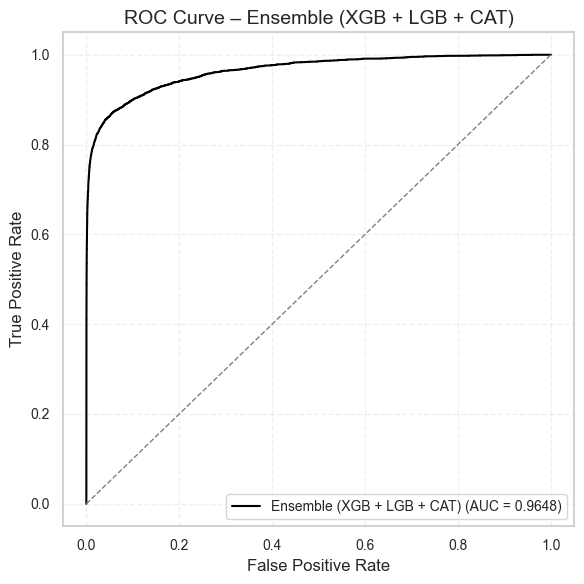

In [ ]:
# Plot ROC Curve for ensemble model (Voting Classifier)
plot_roc_with_auc(
    y_true=y_test,
    y_proba=y_proba_ensemble,
    model_name="Ensemble (XGB + LGB + CAT)",
    color="black",
    save=True
)

In [208]:
# save model metrics to CSV
save_model_metrics_csv(
    model_name="Ensemble (XGB + LGB + CAT)",
    y_true=y_test,
    y_pred=y_pred_ensemble,
    y_proba=y_proba_ensemble,
    filepath="../reports/model_metrics.csv"
)

✅ Metrics saved to: ../reports/model_metrics.csv


The ensemble improved robustness, slightly increased F1 and AUC, and offered better balance between precision and recall:
- Accuracy: ~0.984
- Precision (Fraud): ~0.955
- Recall (Fraud): ~0.571
- F1 Score: ~0.715
- ROC–AUC: ~0.9648

### 8.2 Stacking Classifier

We built a `StackingClassifier` using the three best tree-based models as base learners and `LogisticRegression` as the final meta-model. The stacking ensemble learns to combine the outputs of base classifiers using cross-validation.

- Base models: `XGBoost`, `LightGBM`, `CatBoost`
- Meta-model: `LogisticRegression`

In [213]:
stacking_model = StackingClassifier(
    estimators=[
        ("xgb", best_xgb_model),
        ("lgb", best_lgb_model),
        ("cat", cat_model_tuned)
    ],
    final_estimator=LogisticRegression(max_iter=1000)  # or XGBClassifier()
)
# training
stacking_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38677
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 432
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
[LightGBM] [Info] Number of positive: 13224, number of negative: 364721
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38755
[LightGBM] [Info] Number of data points in the train set: 377945, number of used features: 431
[LightGBM]

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None,
                                              feature_weights=None, gamma=0,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constrai...
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=500, n_jobs=-1,
                                              num_parallel_tree=None, ...)),
                               ('lgb',
                                LGBMClassifier(max_depth=10,
                                               min_child_samples=10,
                                               n_estimators=500, n_jobs=-1,
                                               num_leaves=63, random_state=42,
                                               subsample=0.6)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x10efd37c0>)],
                   final_estimator=LogisticRegression(max_iter=1000))

In [214]:
y_pred_stack = stacking_model.predict(X_test)
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

In [ ]:
# classification report for stacking model
print_classification_report(
    y_true=y_test,
    y_pred=y_pred_stack,
    model_name="Stacking (Meta: LogisticRegression)"
)


📋 Classification Report – Stacking (Meta: LogisticRegression)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    113975
         1.0       0.92      0.68      0.78      4133

    accuracy                           0.99    118108
   macro avg       0.96      0.84      0.89    118108
weighted avg       0.99      0.99      0.99    118108



📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/conf_matrix_stacking_(meta:_logisticregression).png


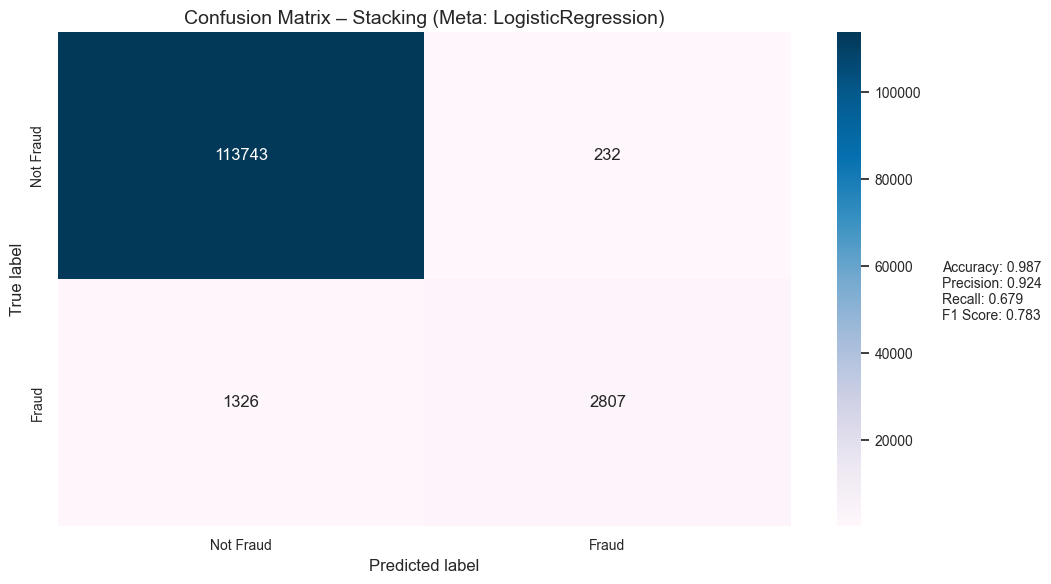

In [219]:
plot_confusion_matrix_with_metrics(
    y_true=y_test,
    y_pred=y_pred_stack,
    model_name="Stacking (Meta: LogisticRegression)",
    cmap="PuBu",
    save=True
)

📁 Figure saved to: /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/reports/figures/roc_curve_stacking_(meta:_logisticregression).png


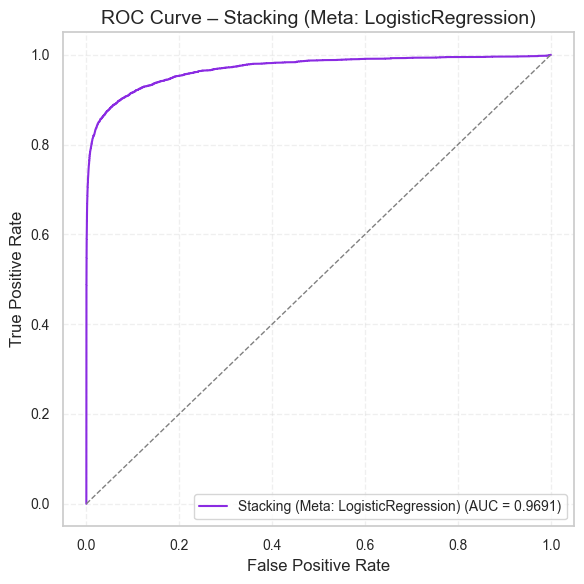

In [220]:
plot_roc_with_auc(
    y_true=y_test,
    y_proba=y_proba_stack,
    model_name="Stacking (Meta: LogisticRegression)",
    color="blueviolet",
    save=True
)

In [218]:
save_model_metrics_csv(
    model_name="Stacking (Meta: LogisticRegression)",
    y_true=y_test,
    y_pred=y_pred_stack,
    y_proba=y_proba_stack,
    filepath="../reports/model_metrics.csv"
)

✅ Metrics saved to: ../reports/model_metrics.csv


Results:
- **Accuracy**: 0.9868  
- **Precision (Fraud)**: 0.9237
- **Recall (Fraud)**: 0.6792 
- **F1 Score**: 0.7828
- **ROC–AUC**: 0.9691

Stacking yielded slightly better recall and F1 score than the soft-voting ensemble, showing it can capture non-linear combinations of model outputs.

## 9 Model Comparison

### 9.1 Read and sort data (by ROC AUC)

In [221]:
# Read model metrics CSV
metrics_df = pd.read_csv("../reports/model_metrics.csv")

metrics_sorted = metrics_df.sort_values("ROC AUC", ascending=False)

### 📈 9.2 Barplots comparison

- **ROC AUC**

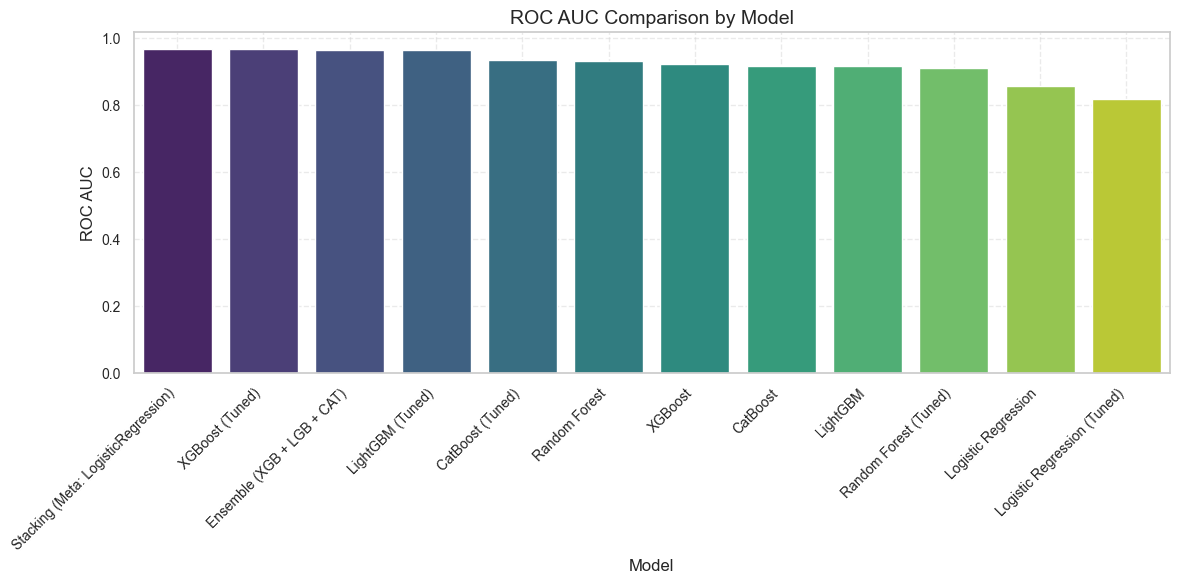

In [222]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="ROC AUC", data=metrics_sorted, palette="viridis")
plt.title("ROC AUC Comparison by Model")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

- **F1 Score**

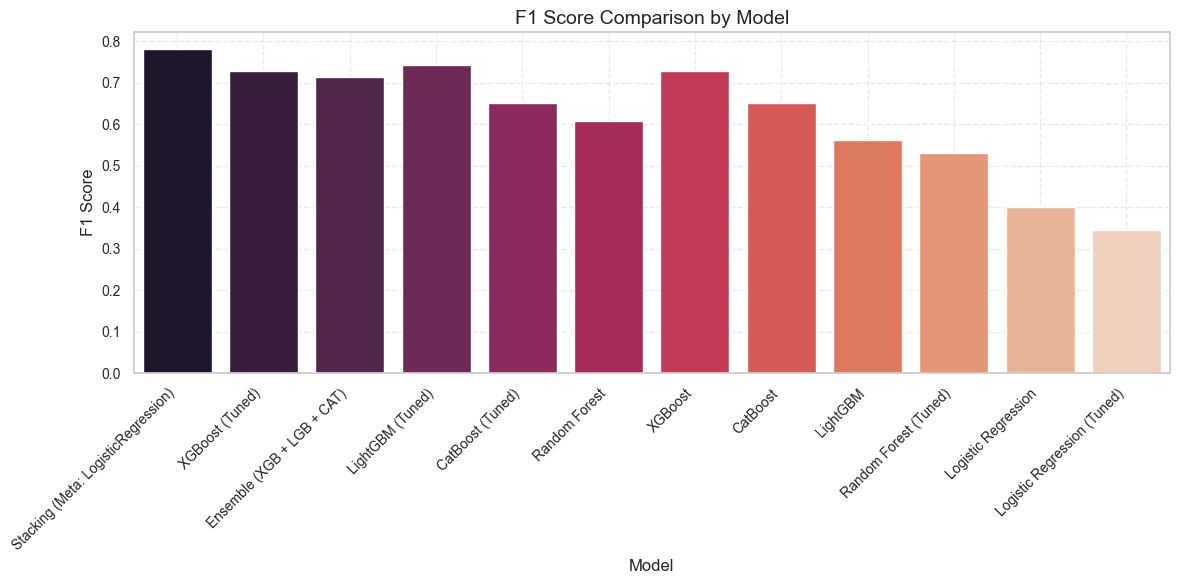

In [223]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="F1 Score", data=metrics_sorted, palette="rocket")
plt.title("F1 Score Comparison by Model")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

- **Recall**

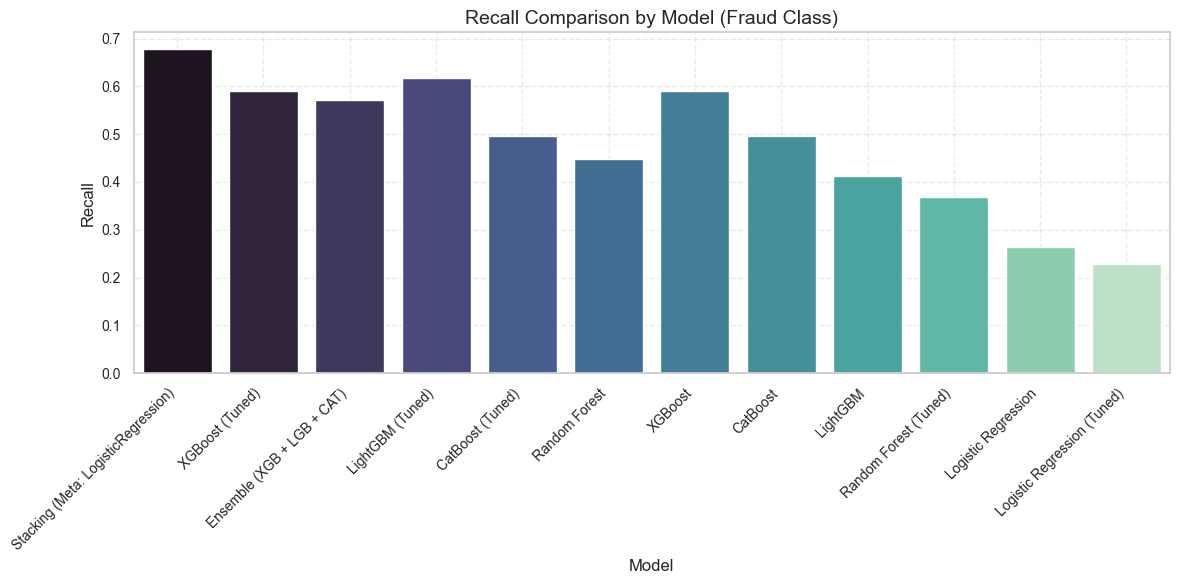

In [224]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Recall", data=metrics_sorted, palette="mako")
plt.title("Recall Comparison by Model (Fraud Class)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

### 9.3 Summary table sorted by AUC

In [225]:
from IPython.display import display

# Tabla con gradientes visuales
display(metrics_sorted.style.background_gradient(cmap="Purples"))

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
11,Stacking (Meta: LogisticRegression),0.986800,0.923700,0.679200,0.782800,0.969100
7,XGBoost (Tuned),0.984700,0.956800,0.589400,0.729500,0.968900
10,Ensemble (XGB + LGB + CAT),0.984100,0.954700,0.571500,0.715000,0.964800
8,LightGBM (Tuned),0.985100,0.934800,0.617500,0.743700,0.964300
9,CatBoost (Tuned),0.981400,0.945700,0.497000,0.651500,0.935100
1,Random Forest,0.979700,0.941600,0.448600,0.607700,0.932600
2,XGBoost,0.984700,0.956800,0.589400,0.729500,0.923400
4,CatBoost,0.981400,0.945700,0.497000,0.651500,0.917400
3,LightGBM,0.977500,0.882000,0.412500,0.562100,0.915700
6,Random Forest (Tuned),0.977100,0.936800,0.369500,0.529900,0.910900


### 9.4 Additional Plots for publications

In [226]:
# Normalize metrics for better comparison
metrics_norm = metrics_sorted.copy()
metrics_cols = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
metrics_norm[metrics_cols] = metrics_sorted[metrics_cols].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

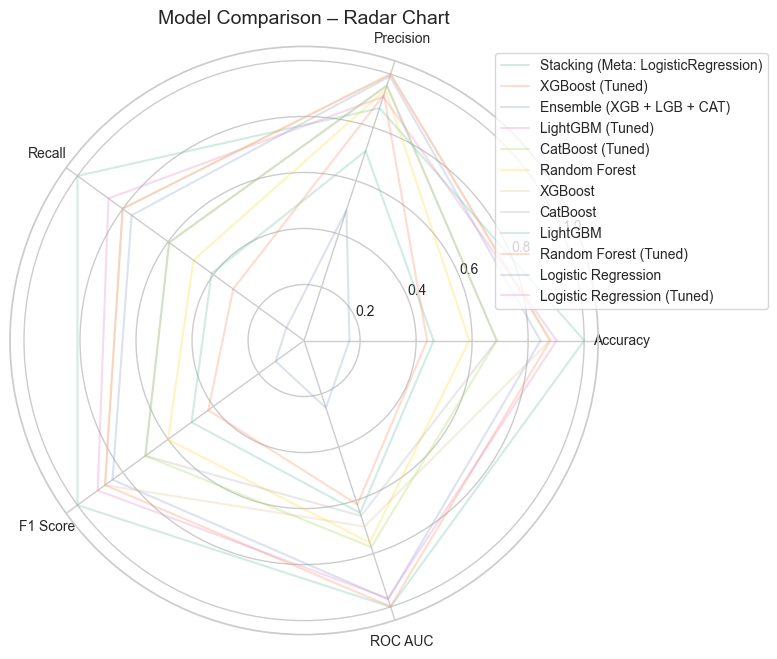

In [227]:
labels = metrics_cols
num_vars = len(labels)

# Set up figure
plt.figure(figsize=(8, 8))
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close loop

for i, row in metrics_norm.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    plt.polar(angles, values, label=row["Model"], alpha=0.3)

plt.xticks(angles[:-1], labels)
plt.title("Model Comparison – Radar Chart")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

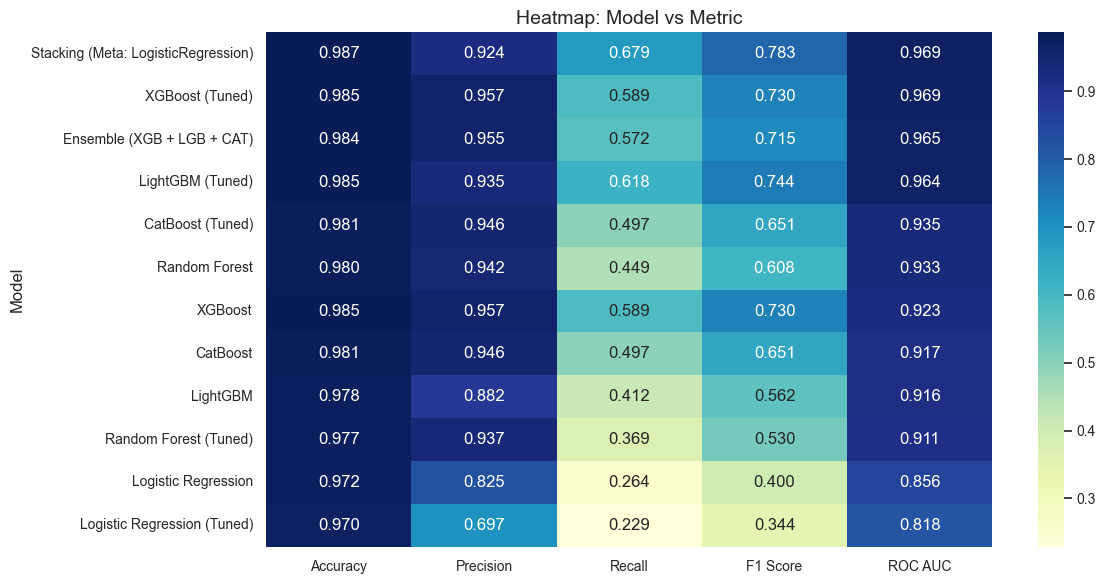

In [233]:
fig = plt.figure(figsize=(12, 6))
sns.heatmap(metrics_sorted.set_index("Model")[metrics_cols], annot=True, fmt=".3f", cmap="YlGnBu")
fig.savefig("../reports/figures/model_comparison_heatmap.png", bbox_inches='tight', dpi=300)
plt.title("Heatmap: Model vs Metric")
plt.tight_layout()
plt.show()

### 🔍 Final Model Comparison

From the comparison above, we observe:

- `Stacking (Meta: LogisticRegression)` achieved the **highest AUC (0.9691)** and **F1 Score (0.7828)**, making it the most balanced model overall.
- The **Voting Ensemble** also performed competitively, with a solid AUC of 0.9648 and F1 of 0.715.
- Among single models, **XGBoost (Tuned)** and **LightGBM (Tuned)** were the top performers.

The stacking ensemble is selected as the final model for deployment due to its superior balance between recall, precision, and AUC.

- **🧩 Limitations and Future Work:**
While the stacking model performed best, further improvements could involve trying XGB as meta-model, experimenting with class rebalancing techniques, or deploying the model to an API for real-time inference.

## 10. Model Saving

In [229]:
import joblib
joblib.dump(stacking_model, "../models/final_model_stacking.pkl")

['../models/final_model_stacking.pkl']